In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv
/kaggle/input/ames-housing-dataset/AmesHousing.csv


# 1. Imports

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import skew, norm
import scipy.stats as stats
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor

import xgboost as xgb
from catboost import Pool
from catboost import CatBoostRegressor

import missingno as msno

%matplotlib inline

# 2. Data

In [3]:
# train = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
train = pd.read_csv('/kaggle/input/ames-housing-dataset/AmesHousing.csv')
test = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')

In [4]:
train.columns = train.columns.str.replace(' ', '')
train = train.drop(['Order','PID'], axis = 1)
train

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925,80,RL,37.0,7937,Pave,NaN,IR1,Lvl,AllPub,CulDSac,...,0,NaN,GdPrv,NaN,0,3,2006,WD,Normal,142500
2926,20,RL,NaN,8885,Pave,NaN,IR1,Low,AllPub,Inside,...,0,NaN,MnPrv,NaN,0,6,2006,WD,Normal,131000
2927,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal,132000
2928,20,RL,77.0,10010,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,4,2006,WD,Normal,170000


In [5]:
train.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemod/Add,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,2930.000000,2440.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2907.000000,2929.000000,2929.000000,...,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000
mean,57.387372,69.224590,10147.921843,6.094881,5.563140,1971.356314,1984.266553,101.896801,442.629566,49.722431,...,93.751877,47.533447,23.011604,2.592491,16.002048,2.243345,50.635154,6.216041,2007.790444,180796.060068
std,42.638025,23.365335,7880.017759,1.411026,1.111537,30.245361,20.860286,179.112611,455.590839,169.168476,...,126.361562,67.483400,64.139059,25.141331,56.087370,35.597181,566.344288,2.714492,1.316613,79886.692357
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,12789.000000
25%,20.000000,58.000000,7440.250000,5.000000,5.000000,1954.000000,1965.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000,129500.000000
50%,50.000000,68.000000,9436.500000,6.000000,5.000000,1973.000000,1993.000000,0.000000,370.000000,0.000000,...,0.000000,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,160000.000000
75%,70.000000,80.000000,11555.250000,7.000000,6.000000,2001.000000,2004.000000,164.000000,734.000000,0.000000,...,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,213500.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1526.000000,...,1424.000000,742.000000,1012.000000,508.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000,755000.000000


In [6]:
test.drop('Id', axis=1, inplace=True)
test

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
1455,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
1456,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml
1457,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal


In [7]:
train_test = pd.concat([train, test], axis=0, ignore_index=True)
train_test

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,YearRemodAdd
0,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,AllPub,Corner,...,NaN,NaN,NaN,0,5,2010,WD,Normal,215000.0,NaN
1,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,...,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000.0,NaN
2,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,...,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000.0,NaN
3,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,AllPub,Corner,...,NaN,NaN,NaN,0,4,2010,WD,Normal,244000.0,NaN
4,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,...,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4384,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,Inside,...,NaN,NaN,NaN,0,6,2006,WD,Normal,NaN,1970.0
4385,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,Inside,...,NaN,NaN,NaN,0,4,2006,WD,Abnorml,NaN,1970.0
4386,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,...,NaN,NaN,NaN,0,9,2006,WD,Abnorml,NaN,1996.0
4387,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,Inside,...,NaN,MnPrv,Shed,700,7,2006,WD,Normal,NaN,1992.0


<Axes: >

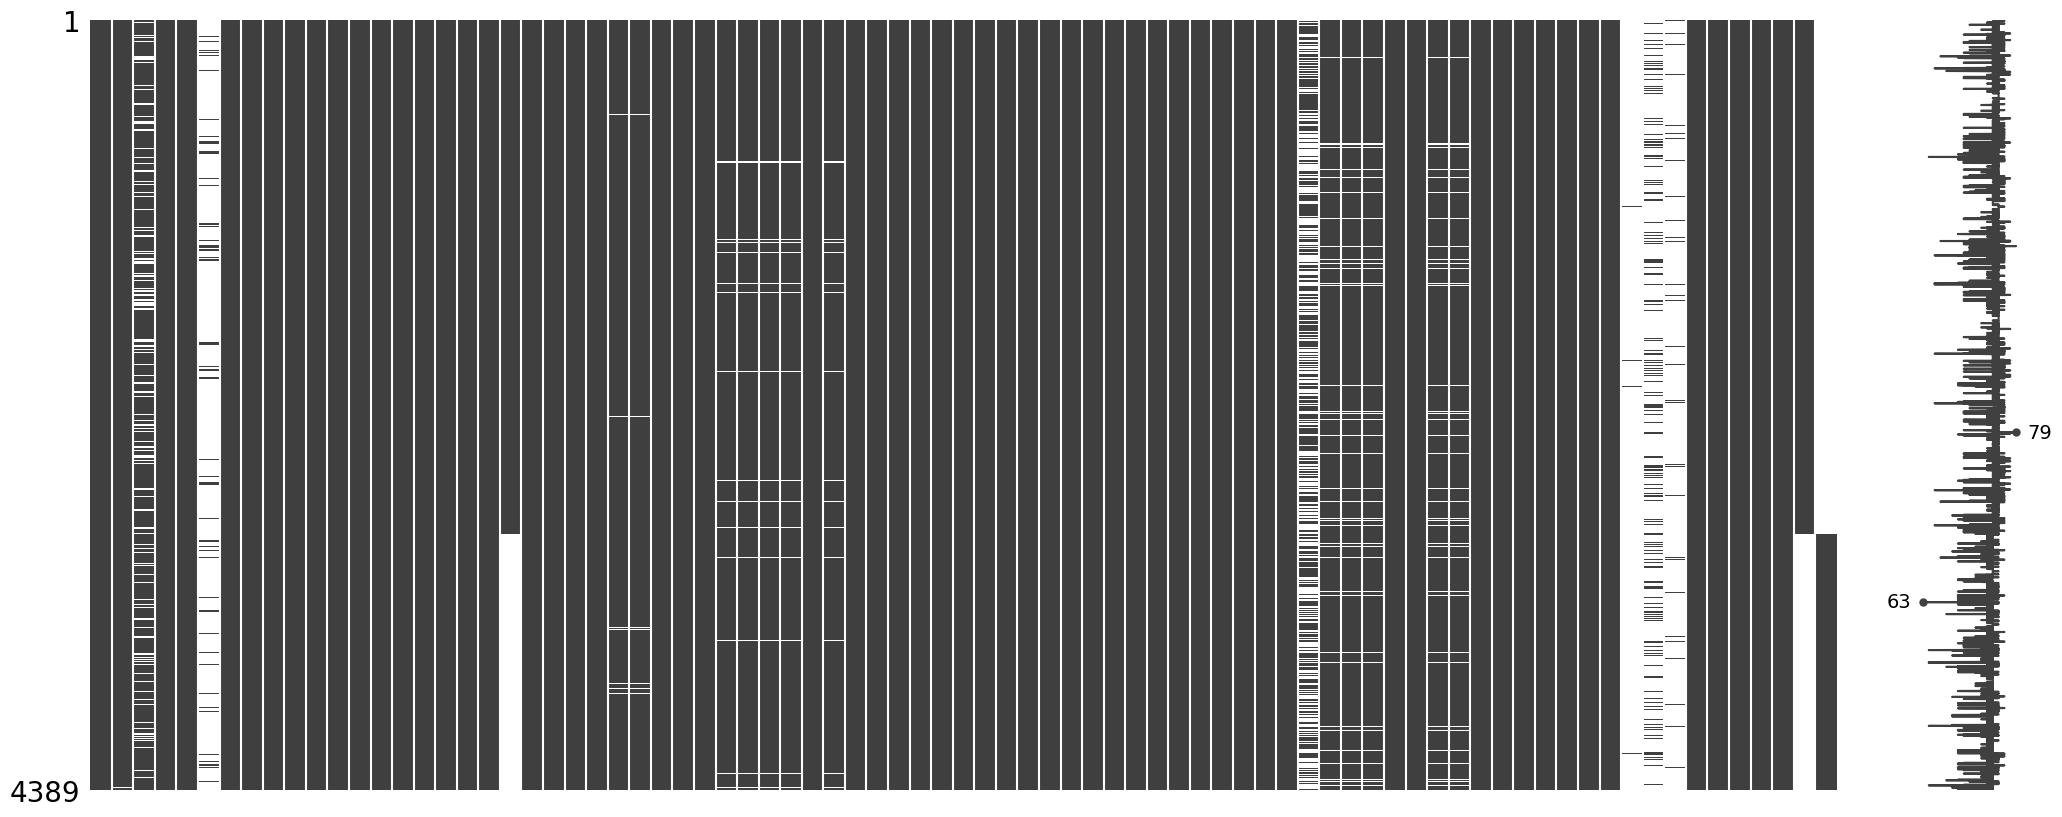

In [8]:
msno.matrix(train_test)

In [9]:
def missing_percentage(df):
    """This function takes a DataFrame(df) as input and returns two columns, total missing values and total missing values percentage"""
    ## the two following line may seem complicated but its actually very simple. 
    total = df.isnull().sum().sort_values(ascending = False)[df.isnull().sum().sort_values(ascending = False) != 0]
    percent = round(df.isnull().sum().sort_values(ascending = False)/len(df)*100,2)[round(df.isnull().sum().sort_values(ascending = False)/len(df)*100,2) != 0]
    return pd.concat([total, percent], axis=1, keys=['Total','Percent'])

missing_percentage(train_test)

,Total,Percent
PoolQC,4373,99.64
MiscFeature,4232,96.42
Alley,4084,93.05
Fence,3527,80.36
YearRemodAdd,2930,66.76
FireplaceQu,2152,49.03
YearRemod/Add,1459,33.24
SalePrice,1459,33.24
LotFrontage,717,16.34
GarageYrBlt,237,5.40


In [10]:
numerical_features = train_test.select_dtypes(include=[int, float]).columns.tolist()
categorical_features = train_test.select_dtypes(include='object').columns.tolist()

# 3. EDA

#### Sale Price

/tmp/ipykernel_20/1390344820.py:21: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.loc[:,feature], norm_hist=True, ax = ax1)


Skewness: 1.7435000757376466
Kurtosis: 5.118899951130896


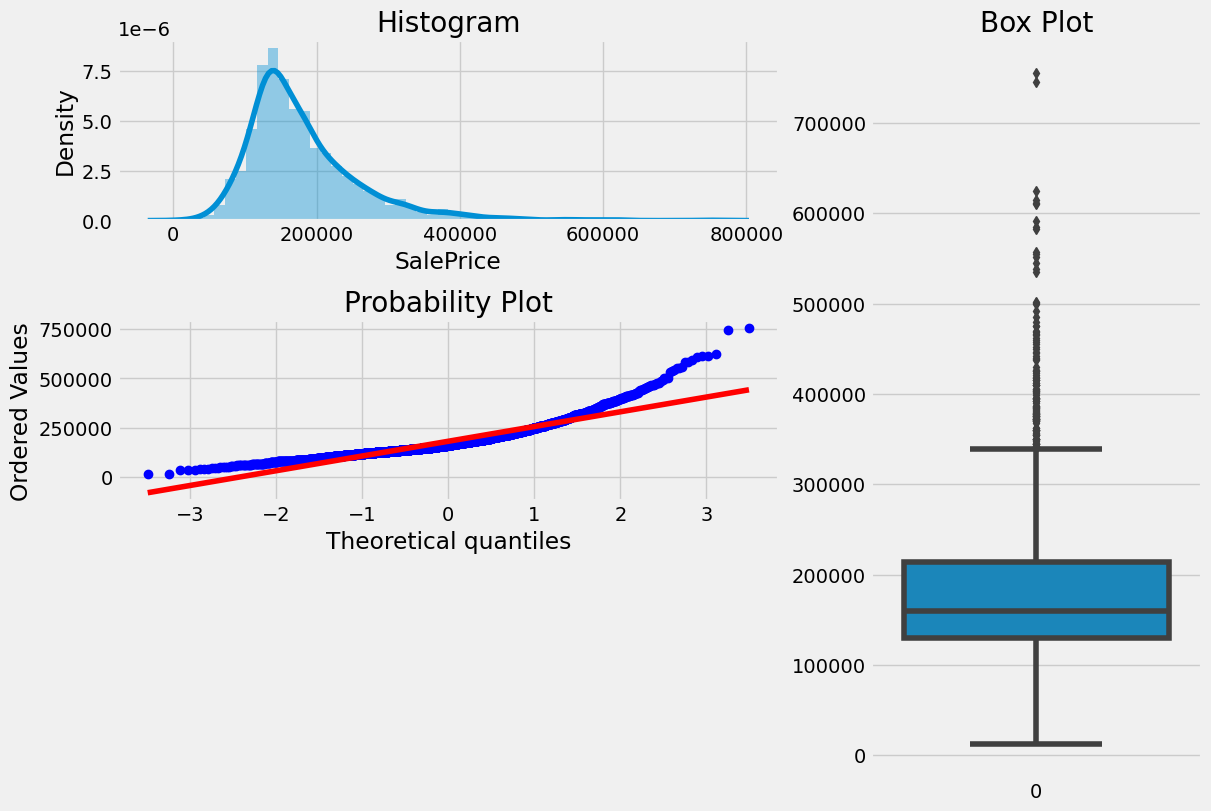

In [11]:
def plotting_3_chart(df, feature):
    ## Importing seaborn, matplotlab and scipy modules. 
    import seaborn as sns
    import matplotlib.pyplot as plt
    import matplotlib.gridspec as gridspec
    from scipy import stats
    import matplotlib.style as style
    style.use('fivethirtyeight')

    ## Creating a customized chart. and giving in figsize and everything. 
    fig = plt.figure(constrained_layout=True, figsize=(12,8))
    ## creating a grid of 3 cols and 3 rows. 
    grid = gridspec.GridSpec(ncols=3, nrows=3, figure=fig)
    #gs = fig3.add_gridspec(3, 3)

    ## Customizing the histogram grid. 
    ax1 = fig.add_subplot(grid[0, :2])
    ## Set the title. 
    ax1.set_title('Histogram')
    ## plot the histogram. 
    sns.distplot(df.loc[:,feature], norm_hist=True, ax = ax1)

    # customizing the QQ_plot. 
    ax2 = fig.add_subplot(grid[1, :2])
    ## Set the title. 
    ax2.set_title('QQ_plot')
    ## Plotting the QQ_Plot. 
    stats.probplot(df.loc[:,feature], plot = ax2)

    ## Customizing the Box Plot. 
    ax3 = fig.add_subplot(grid[:, 2])
    ## Set title. 
    ax3.set_title('Box Plot')
    ## Plotting the box plot. 
    sns.boxplot(df.loc[:,feature], orient='v', ax = ax3 );

    #skewness and kurtosis
    print("Skewness: " + str(df[feature].skew()))
    print("Kurtosis: " + str(df[feature].kurt()))

plotting_3_chart(train, 'SalePrice')

#### Correlation

In [12]:
## Getting the correlation of all the features with target variable. 
num_cols = [col for col in train.columns if train[col].dtype != "O"]
(train[num_cols].corr())["SalePrice"].sort_values(ascending = False)[1:]

OverallQual      0.799262
GrLivArea        0.706780
GarageCars       0.647877
GarageArea       0.640401
TotalBsmtSF      0.632280
1stFlrSF         0.621676
YearBuilt        0.558426
FullBath         0.545604
YearRemod/Add    0.532974
GarageYrBlt      0.526965
MasVnrArea       0.508285
TotRmsAbvGrd     0.495474
Fireplaces       0.474558
BsmtFinSF1       0.432914
LotFrontage      0.357318
WoodDeckSF       0.327143
OpenPorchSF      0.312951
HalfBath         0.285056
BsmtFullBath     0.276050
2ndFlrSF         0.269373
LotArea          0.266549
BsmtUnfSF        0.182855
BedroomAbvGr     0.143913
ScreenPorch      0.112151
PoolArea         0.068403
MoSold           0.035259
3SsnPorch        0.032225
BsmtFinSF2       0.005891
MiscVal         -0.015691
YrSold          -0.030569
BsmtHalfBath    -0.035835
LowQualFinSF    -0.037660
MSSubClass      -0.085092
OverallCond     -0.101697
KitchenAbvGr    -0.119814
EnclosedPorch   -0.128787
Name: SalePrice, dtype: float64

/tmp/ipykernel_20/4181184237.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = train_test.corr()


<Axes: >

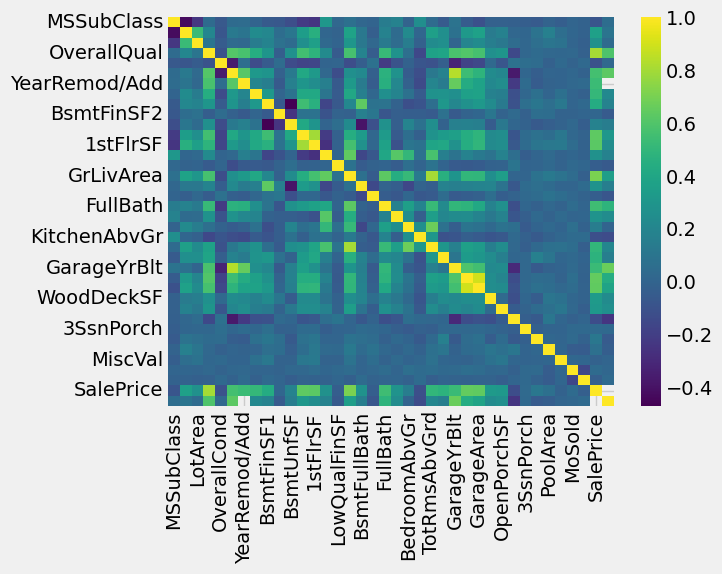

In [13]:
corr = train_test.corr()
sns.heatmap(corr, cmap='viridis')

#### Distribution of Numerical Features

array([[<Axes: title={'center': 'MSSubClass'}>,
        <Axes: title={'center': 'LotFrontage'}>,
        <Axes: title={'center': 'LotArea'}>,
        <Axes: title={'center': 'OverallQual'}>,
        <Axes: title={'center': 'OverallCond'}>,
        <Axes: title={'center': 'YearBuilt'}>],
       [<Axes: title={'center': 'YearRemod/Add'}>,
        <Axes: title={'center': 'MasVnrArea'}>,
        <Axes: title={'center': 'BsmtFinSF1'}>,
        <Axes: title={'center': 'BsmtFinSF2'}>,
        <Axes: title={'center': 'BsmtUnfSF'}>,
        <Axes: title={'center': 'TotalBsmtSF'}>],
       [<Axes: title={'center': '1stFlrSF'}>,
        <Axes: title={'center': '2ndFlrSF'}>,
        <Axes: title={'center': 'LowQualFinSF'}>,
        <Axes: title={'center': 'GrLivArea'}>,
        <Axes: title={'center': 'BsmtFullBath'}>,
        <Axes: title={'center': 'BsmtHalfBath'}>],
       [<Axes: title={'center': 'FullBath'}>,
        <Axes: title={'center': 'HalfBath'}>,
        <Axes: title={'center': 'Bedro

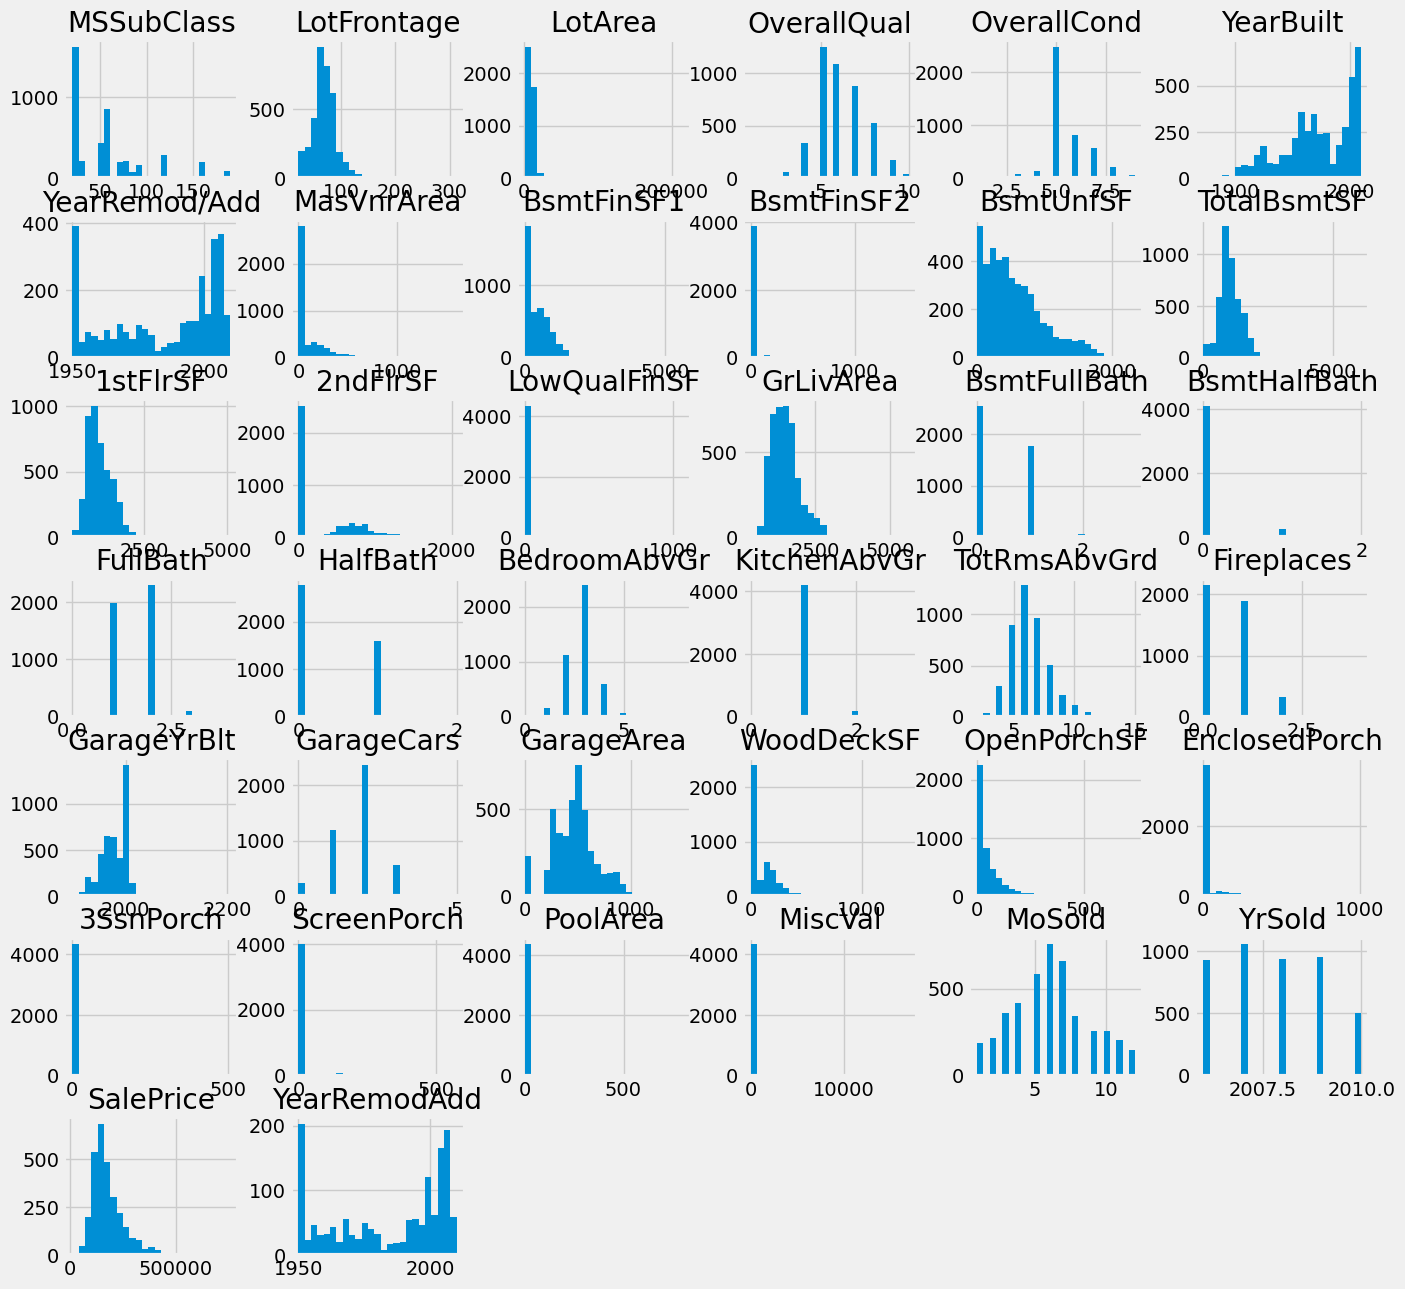

In [14]:
train_test[numerical_features].hist(bins=25, figsize=(15, 15))

##### NOTE: We can see that some of the features are highly right skewed

#### Pairplots

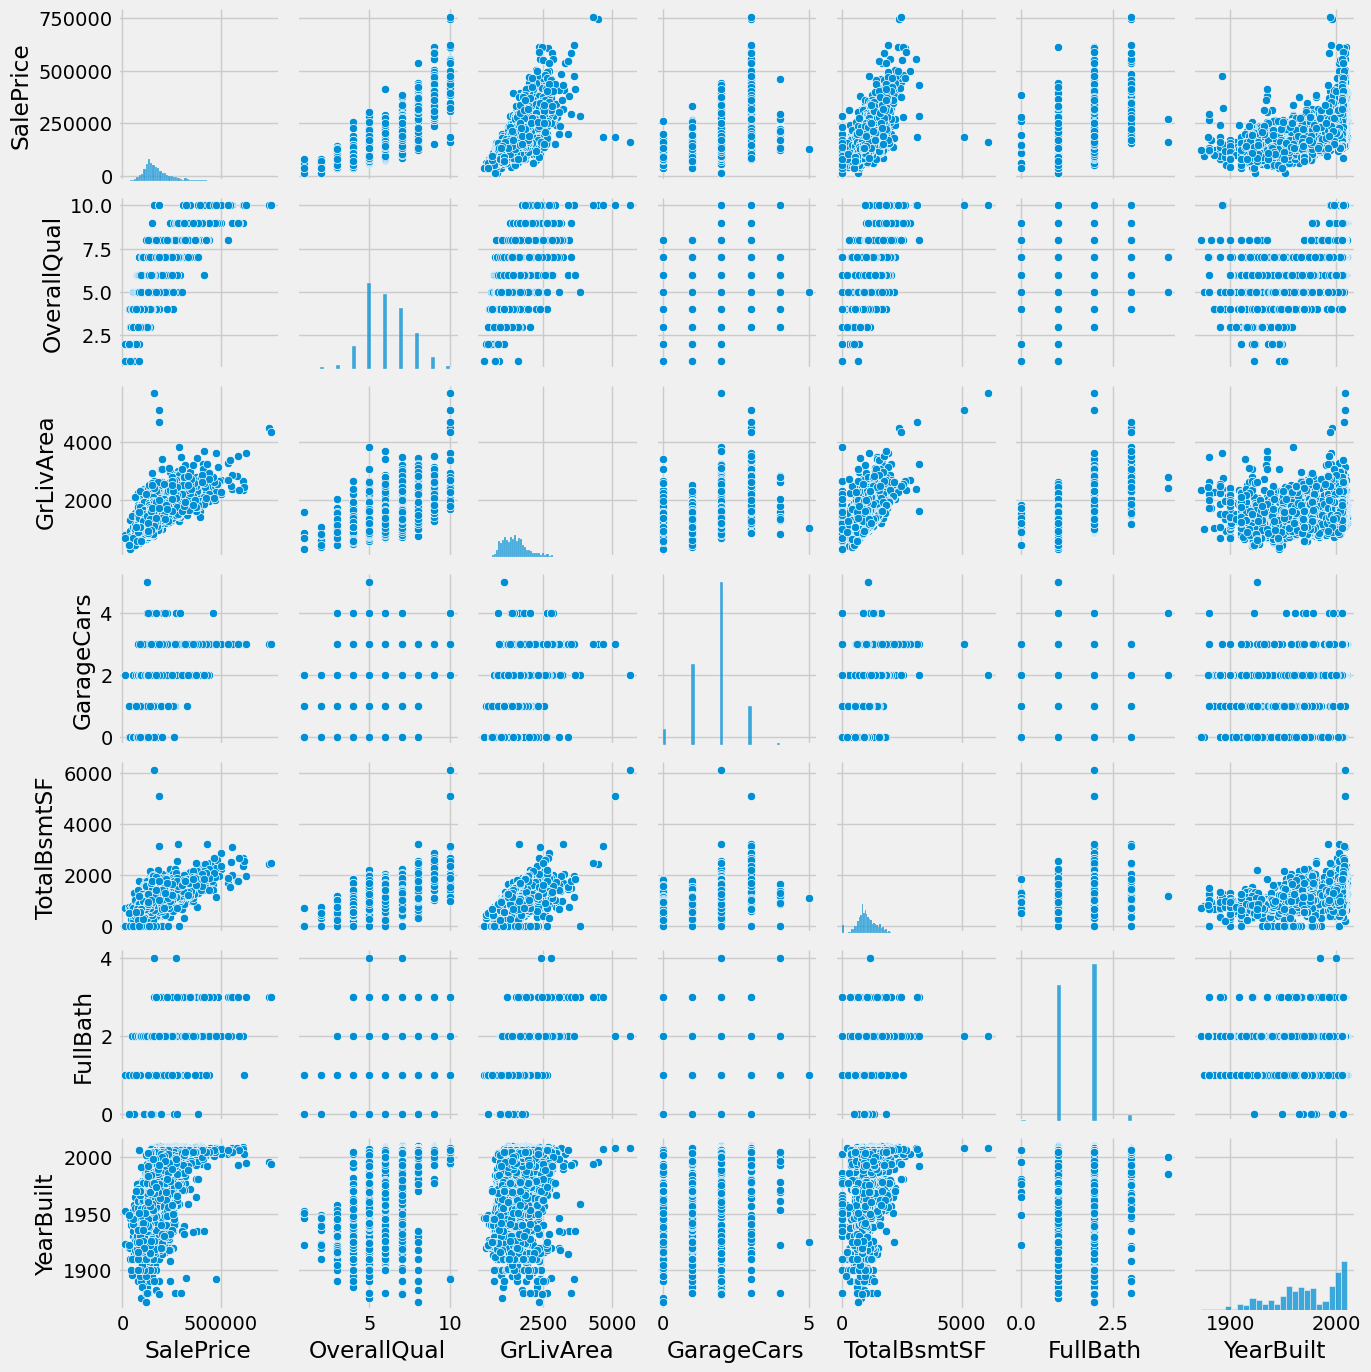

In [15]:
selected_features = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(data=train_test[selected_features], height=2)

#### GrLivArea

<Axes: xlabel='GrLivArea', ylabel='SalePrice'>

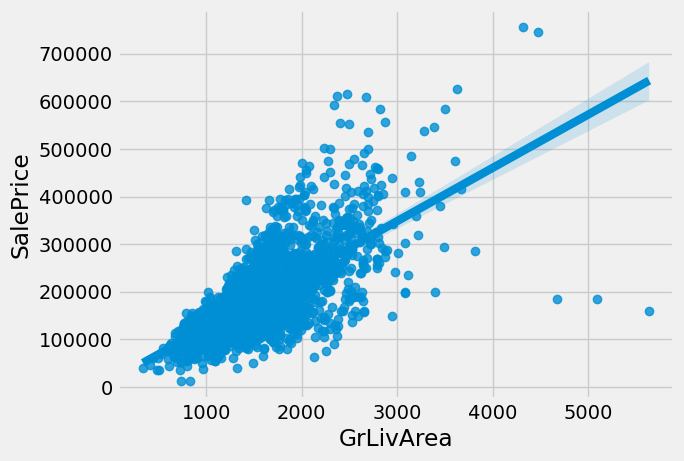

In [16]:
sns.regplot(data=train_test, x='GrLivArea', y='SalePrice')

#### TotalBsmtSF

<Axes: xlabel='TotalBsmtSF', ylabel='SalePrice'>

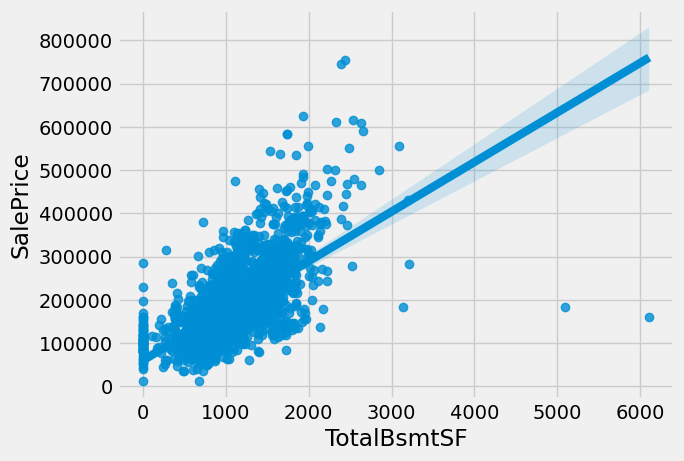

In [17]:
sns.regplot(data=train_test, x='TotalBsmtSF', y='SalePrice')

#### OverallQual

<Axes: xlabel='OverallQual', ylabel='SalePrice'>

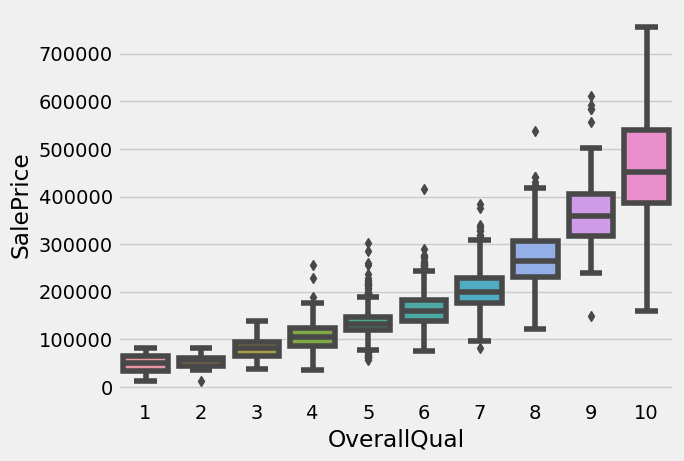

In [18]:
sns.boxplot(data=train_test, y='SalePrice', x='OverallQual')

#### YearBuilt

<Axes: xlabel='YearBuilt', ylabel='SalePrice'>

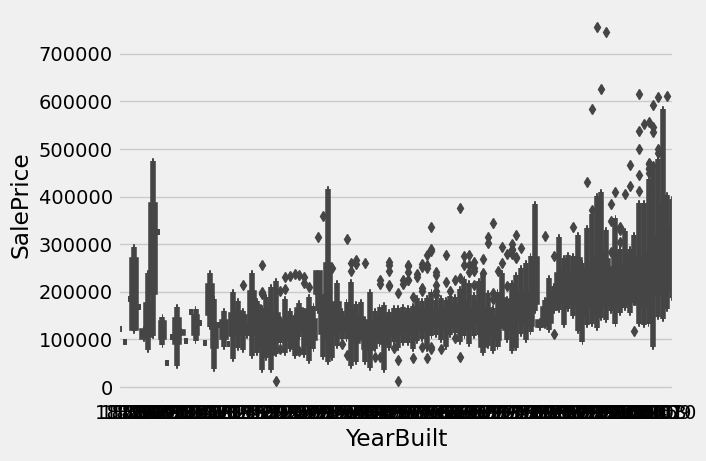

In [19]:
sns.boxplot(data=train_test, x='YearBuilt', y='SalePrice')

# 4. Preprocessing & Feature Engineering

In [20]:
# Converting non-numeric predictors stored as numbers into string
train_test['MSSubClass'] = train_test['MSSubClass'].apply(str)
train_test['YrSold'] = train_test['YrSold'].apply(str)
train_test['MoSold'] = train_test['MoSold'].apply(str)

#### Fill NA based on data description file

In [21]:
train_test['Functional'] = train_test['Functional'].fillna('Typ')
train_test['Electrical'] = train_test['Electrical'].fillna("SBrkr")
train_test['KitchenQual'] = train_test['KitchenQual'].fillna("TA")
train_test['Exterior1st'] = train_test['Exterior1st'].fillna(train_test['Exterior1st'].mode()[0])
train_test['Exterior2nd'] = train_test['Exterior2nd'].fillna(train_test['Exterior2nd'].mode()[0])
train_test['SaleType'] = train_test['SaleType'].fillna(train_test['SaleType'].mode()[0])
train_test["PoolQC"] = train_test["PoolQC"].fillna("None")
train_test["Alley"] = train_test["Alley"].fillna("None")
train_test['FireplaceQu'] = train_test['FireplaceQu'].fillna("None")
train_test['Fence'] = train_test['Fence'].fillna("None")
train_test['MiscFeature'] = train_test['MiscFeature'].fillna("None")

for col in ('GarageArea', 'GarageCars'):
    train_test[col] = train_test[col].fillna(0)
        
for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
    train_test[col] = train_test[col].fillna('None')
    
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    train_test[col] = train_test[col].fillna('None')

#### Removing the unneeded features

In [22]:
useless = ['GarageYrBlt', 'YearRemodAdd'] 
train_test.drop(useless, axis=1, inplace=True)

#### Check columns with missing values

In [23]:
missing_values = train_test.isnull().sum()
columns_with_missing = missing_values[missing_values > 0].index.tolist()
columns_with_missing = [col for col in columns_with_missing if train_test[col].isnull().any()]

print("Columns with missing values:", columns_with_missing)

Columns with missing values: ['MSZoning', 'LotFrontage', 'Utilities', 'YearRemod/Add', 'MasVnrType', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'SalePrice']


#### Imputation

In [24]:
def impute_knn(df):
    ttn = train_test.select_dtypes(include=[np.number])
    ttc = train_test.select_dtypes(exclude=[np.number])

    cols_nan = ttn.columns[ttn.isna().any()].tolist()         # columns w/ nan 
    cols_no_nan = ttn.columns.difference(cols_nan).values     # columns w/n nan

    for col in cols_nan:
        imp_test = ttn[ttn[col].isna()]   # indicies which have missing data will become our test set
        imp_train = ttn.dropna()          # all indicies which which have no missing data 
        model = KNeighborsRegressor(n_neighbors=5)  # KNR Unsupervised Approach
        knr = model.fit(imp_train[cols_no_nan], imp_train[col])
        ttn.loc[ttn[col].isna(), col] = knr.predict(imp_test[cols_no_nan])
    
    return pd.concat([ttn, ttc],axis=1)

train_test = impute_knn(train_test)

In [25]:
objects = []
for i in train_test.columns:
    if train_test[i].dtype == object:
        objects.append(i)
train_test.update(train_test[objects].fillna('None'))
         
train_test[columns_with_missing].isna().sum()

MSZoning         0
LotFrontage      0
Utilities        0
YearRemod/Add    0
MasVnrType       0
MasVnrArea       0
BsmtFinSF1       0
BsmtFinSF2       0
BsmtUnfSF        0
TotalBsmtSF      0
BsmtFullBath     0
BsmtHalfBath     0
SalePrice        0
dtype: int64

#### Feature Engineering

In [26]:
train_test["SqFtPerRoom"] = train_test["GrLivArea"] / (train_test["TotRmsAbvGrd"] +
                                                       train_test["FullBath"] +
                                                       train_test["HalfBath"] +
                                                       train_test["KitchenAbvGr"])

train_test['Total_Home_Quality'] = train_test['OverallQual'] + train_test['OverallCond']

train_test['Total_Bathrooms'] = (train_test['FullBath'] + (0.5 * train_test['HalfBath']) +
                               train_test['BsmtFullBath'] + (0.5 * train_test['BsmtHalfBath']))

train_test["HighQualSF"] = train_test["GrLivArea"] + train_test["1stFlrSF"] + train_test["2ndFlrSF"] + 0.5 * train_test["GarageArea"] + 0.5 * train_test["TotalBsmtSF"] + 1 * train_test["MasVnrArea"]

train_test["Age"] = pd.to_numeric(train_test["YrSold"]) - pd.to_numeric(train_test["YearBuilt"])

train_test["Renovate"] = pd.to_numeric(train_test["YearRemod/Add"]) - pd.to_numeric(train_test["YearBuilt"])

#### One Hot Encoding

In [27]:
train_test_dummy = pd.get_dummies(train_test)
train_test_dummy

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemod/Add,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,SaleType_Oth,SaleType_VWD,SaleType_WD,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,141.0,31770,6,5,1960,1960.0,112.0,639.0,0.0,441.0,...,0,0,0,1,0,0,0,0,1,0
1,80.0,11622,5,6,1961,1961.0,0.0,468.0,144.0,270.0,...,0,0,0,1,0,0,0,0,1,0
2,81.0,14267,6,6,1958,1958.0,108.0,923.0,0.0,406.0,...,0,0,0,1,0,0,0,0,1,0
3,93.0,11160,7,5,1968,1968.0,0.0,1065.0,0.0,1045.0,...,0,0,0,1,0,0,0,0,1,0
4,74.0,13830,5,5,1997,1998.0,0.0,791.0,0.0,137.0,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4384,21.0,1936,4,7,1970,1971.6,0.0,0.0,0.0,546.0,...,0,0,1,0,0,0,0,0,1,0
4385,21.0,1894,4,5,1970,1972.0,0.0,252.0,0.0,294.0,...,0,0,1,0,1,0,0,0,0,0
4386,160.0,20000,5,7,1960,1985.2,0.0,1224.0,0.0,0.0,...,0,0,1,0,1,0,0,0,0,0
4387,62.0,10441,5,5,1992,1984.8,0.0,337.0,0.0,575.0,...,0,0,1,0,0,0,0,0,1,0


#### Remove skew

In [28]:
numeric_features = train_test_dummy.dtypes[train_test_dummy.dtypes != object].index
skewed_features = train_test_dummy[numeric_features].apply(lambda x: skew(x)).sort_values(ascending=False)
high_skew = skewed_features[skewed_features > 0.5]
skew_index = high_skew.index
    
for i in skew_index:
    train_test_dummy[i] = np.log1p(train_test_dummy[i])

/opt/conda/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/conda/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


#### Log Transform Target (SalePrice)

/tmp/ipykernel_20/3718381027.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(target_log, kde=True, hist=True, fit=norm, ax=ax[1])


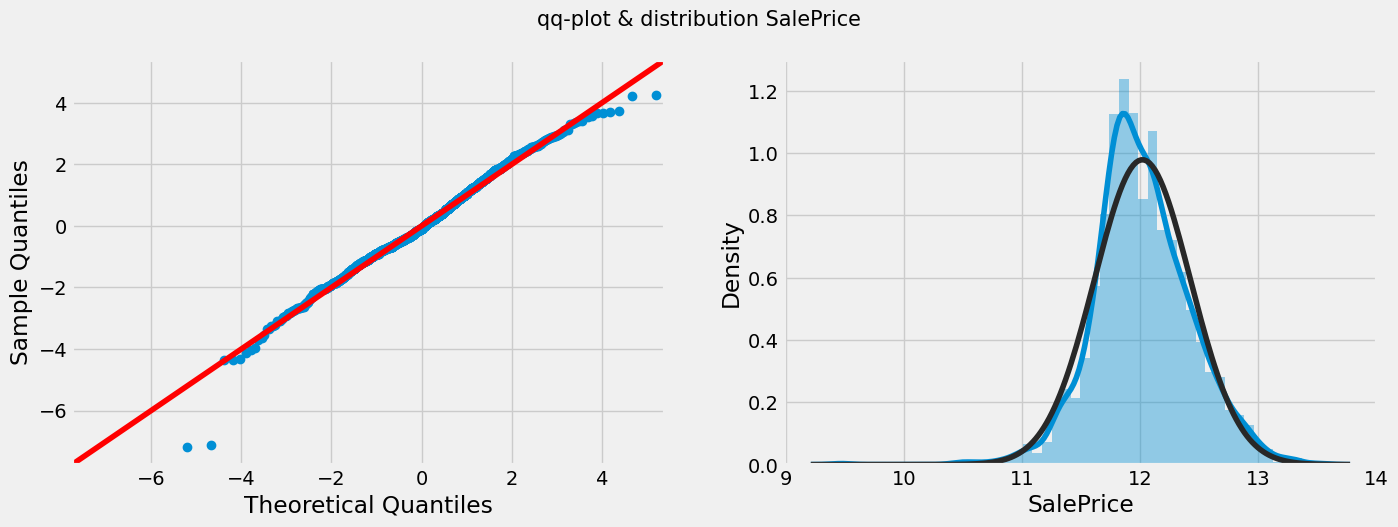

In [29]:
target = train['SalePrice']
target_log = np.log1p(target)

fig, ax = plt.subplots(1, 2, figsize= (15, 5))
fig.suptitle("qq-plot & distribution SalePrice ", fontsize=15)

sm.qqplot(target_log, stats.t, distargs=(4,),fit=True, line="45", ax=ax[0])
sns.distplot(target_log, kde=True, hist=True, fit=norm, ax=ax[1])
plt.show()

#### Log Transform HighQualSF

/tmp/ipykernel_20/2717587216.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(HighQualSF_log, kde=True, hist=True, fit=norm, ax=ax[1])


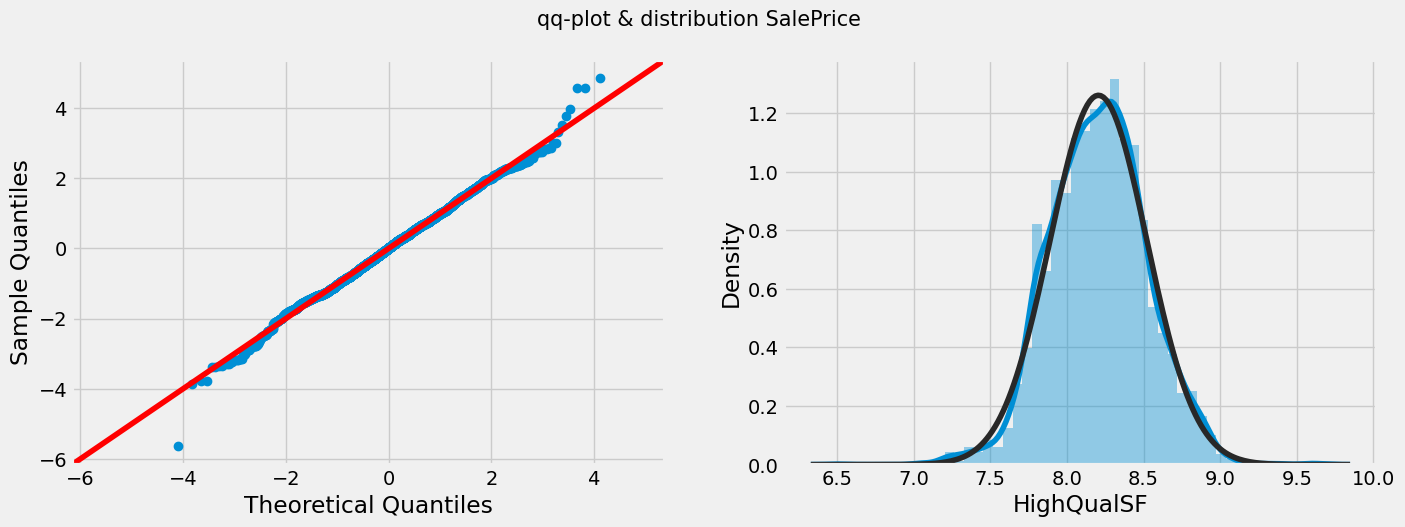

In [30]:
HighQualSF_log = np.log1p(train_test["HighQualSF"])

fig, ax = plt.subplots(1, 2, figsize= (15, 5))
fig.suptitle("qq-plot & distribution SalePrice ", fontsize=15)

sm.qqplot(HighQualSF_log, stats.t, distargs=(4,), fit=True, line="45", ax=ax[0])
sns.distplot(HighQualSF_log, kde=True, hist=True, fit=norm, ax=ax[1])
plt.show()

train_test["HighQualSF"] = HighQualSF_log

#### Log Tranform GrLivArea

/tmp/ipykernel_20/1936003303.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(GrLivArea_log, kde=True, hist=True, fit = norm, ax=ax[1])


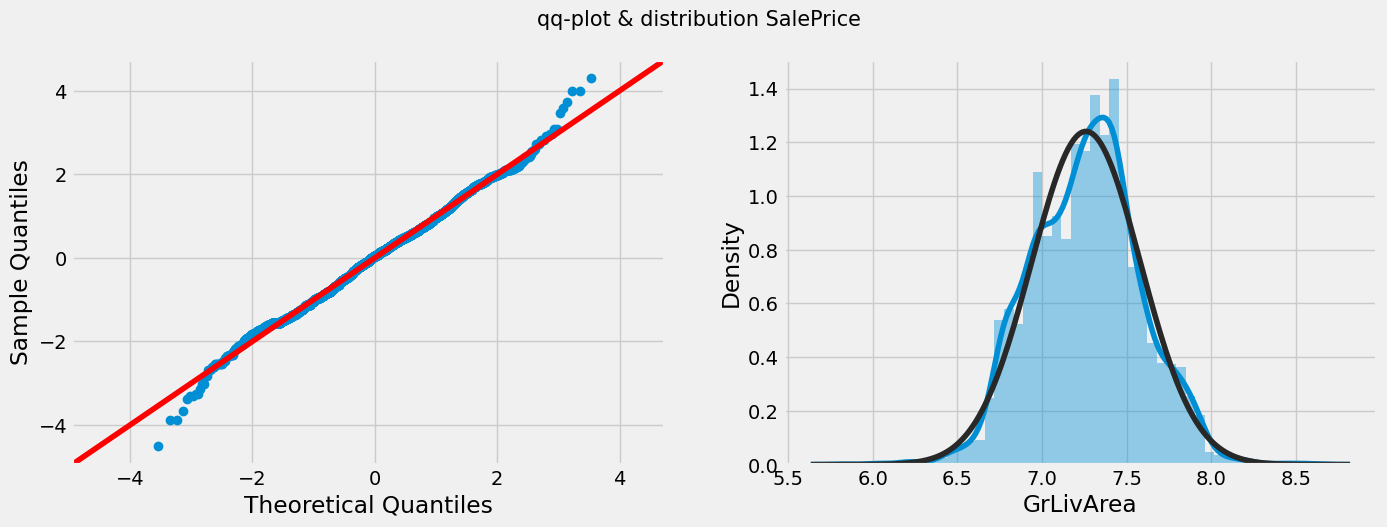

In [31]:
GrLivArea_log = np.log1p(train_test["GrLivArea"])

fig, ax = plt.subplots(1, 2, figsize= (15,5))
fig.suptitle("qq-plot & distribution SalePrice ", fontsize=15)

sm.qqplot(GrLivArea_log, stats.t, distargs=(4,), fit=True, line="45", ax=ax[0])
sns.distplot(GrLivArea_log, kde=True, hist=True, fit = norm, ax=ax[1])
plt.show()

train_test["GrLivArea"]= GrLivArea_log

#### Split back to Train and test

In [32]:
train = train_test_dummy[0:2930]
test = train_test_dummy[2930:]
test.drop('SalePrice', axis=1, inplace=True)

/tmp/ipykernel_20/1158047488.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.drop('SalePrice', axis=1, inplace=True)


In [33]:
ytrain = target_log
xtrain = train.drop('SalePrice', axis=1)

X_train, X_val, y_train, y_val = train_test_split(xtrain, ytrain, test_size=0.5, random_state=42)
X_train, y_train = xtrain, ytrain
X_train

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemod/Add,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,SaleType_Oth,SaleType_VWD,SaleType_WD,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,4.955827,10.366309,6,1.791759,1960,1960.0,4.727388,6.461468,0.000000,6.091310,...,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,1,0.0
1,4.394449,9.360741,5,1.945910,1961,1961.0,0.000000,6.150603,4.976734,5.602119,...,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,1,0.0
2,4.406719,9.565775,6,1.945910,1958,1958.0,4.691348,6.828712,0.000000,6.008813,...,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,1,0.0
3,4.543295,9.320181,7,1.791759,1968,1968.0,0.000000,6.971669,0.000000,6.952729,...,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,1,0.0
4,4.317488,9.534668,5,1.791759,1997,1998.0,0.000000,6.674561,0.000000,4.927254,...,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925,3.637586,8.979417,6,1.945910,1984,1984.0,0.000000,6.709304,0.000000,5.220356,...,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,1,0.0
2926,4.189655,9.092232,5,1.791759,1983,1983.0,0.000000,5.710427,5.783825,5.480639,...,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,1,0.0
2927,4.143135,9.253591,5,1.791759,1992,1992.0,0.000000,5.823046,0.000000,6.356108,...,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,1,0.0
2928,4.356709,9.211440,5,1.791759,1974,1975.0,0.000000,6.977281,4.820282,5.278115,...,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,1,0.0


In [34]:
X_val

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemod/Add,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,SaleType_Oth,SaleType_VWD,SaleType_WD,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
1357,4.036009,8.537192,8,2.079442,1925,1996.0,0.000000,0.000000,0.000000,6.378426,...,0.0,0.0,0.0,1,0.000000,0.0,0.0,0.0,1,0.000000
2367,3.091042,7.544861,6,2.079442,1972,1972.0,5.942799,5.645447,0.000000,5.361292,...,0.0,0.0,0.0,1,0.000000,0.0,0.0,0.0,1,0.000000
2822,4.143135,8.876684,7,1.791759,2003,2004.0,5.252273,0.000000,0.000000,6.680855,...,0.0,0.0,0.0,1,0.000000,0.0,0.0,0.0,1,0.000000
2126,4.110874,8.996033,4,1.791759,1994,1995.0,0.000000,6.378426,0.000000,5.998937,...,0.0,0.0,0.0,1,0.000000,0.0,0.0,0.0,1,0.000000
1544,3.931826,8.853808,6,2.197225,1926,1998.0,0.000000,5.703782,3.713572,6.320768,...,0.0,0.0,0.0,1,0.000000,0.0,0.0,0.0,1,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
576,4.709530,9.643291,7,1.791759,1981,1981.0,0.000000,4.804021,0.000000,7.390181,...,0.0,0.0,0.0,1,0.000000,0.0,0.0,0.0,1,0.000000
2243,4.189655,8.789660,4,1.945910,1957,1980.0,0.000000,6.875232,0.000000,4.672829,...,0.0,0.0,0.0,1,0.693359,0.0,0.0,0.0,0,0.000000
339,4.343805,9.199583,8,1.791759,1994,1995.0,0.000000,7.201916,5.652489,4.007333,...,0.0,0.0,0.0,1,0.000000,0.0,0.0,0.0,1,0.000000
2498,4.615121,9.570180,7,1.609438,1974,1974.0,4.983607,6.931472,6.210600,5.433722,...,0.0,0.0,0.0,1,0.000000,0.0,0.0,0.0,1,0.000000


# 5. Modelling

In [35]:
# best_params = {'max_leaves': 8,
#           'depth': 3,
#           'od_wait': 200,
#           'l2_leaf_reg': 3,
#           'iterations': 200000,
#           'model_size_reg': 0.7,
#           'learning_rate': 0.05,
#           'random_seed': 42 }
# final_model = CatBoostRegressor(**best_params)

final_model = CatBoostRegressor(random_seed=42)

In [36]:
final_model.fit(X_train, y_train, eval_set=(X_val, y_val), verbose=False)

In [37]:
final_model.get_all_params()

{'nan_mode': 'Min',
 'eval_metric': 'RMSE',
 'iterations': 1000,
 'sampling_frequency': 'PerTree',
 'leaf_estimation_method': 'Newton',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'bayesian_matrix_reg': 0.10000000149011612,
 'eval_fraction': 0,
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'rsm': 1,
 'boost_from_average': True,
 'model_size_reg': 0.5,
 'pool_metainfo_options': {'tags': {}},
 'subsample': 0.800000011920929,
 'use_best_model': True,
 'random_seed': 42,
 'depth': 6,
 'posterior_sampling': False,
 'border_count': 254,
 'classes_count': 0,
 'auto_class_weights': 'None',
 'sparse_features_conflict_fraction': 0,
 'leaf_estimation_backtracking': 'AnyImprovement',
 'best_model_min_trees': 1,
 'model_shrink_rate': 0,
 'min_data_in_leaf': 1,
 'loss_function': 'RMSE',
 'learning_rate': 0.06028300151228905,
 'score_function': '

In [38]:
def rmse(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [39]:
final_pred = final_model.predict(X_val)

In [40]:
final_score = rmse(y_val, final_pred)
final_score

0.040724837797444756

# 6. Submission

In [41]:
submission = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv')
test_pred = np.expm1(final_model.predict(test))

In [42]:
submission['SalePrice'] = test_pred
submission

,Id,SalePrice
0,1461,113968.662076
1,1462,166897.193766
2,1463,186987.275324
3,1464,197843.168406
4,1465,191218.448226
...,...,...
1454,2915,86258.116199
1455,2916,76155.117622
1456,2917,135284.033876
1457,2918,128423.139542


In [43]:
submission.to_csv("submission.csv", index=False, header=True)

# 7. References
- https://www.kaggle.com/code/venkatapadavala/house-prices-advanced-regression-practice/notebook
- https://www.kaggle.com/code/pmarcelino/comprehensive-data-exploration-with-python